# Vodafone Challenge
## Scrap notebook
- **Separate each test** you make with a markdown cell like this one (press M when the cursor is on a cell but it is not editing). 
- Put a **small description** on what you are doing and why you do so (like if you manipulate data in a specific way, or apply a particular definition of distance, write the intuition behind. Both for you to remmember later and for team members)
- Make sure you are working with the **proper data** i.e. the data (and their transformation) that you with to use are defined before you do the analysis. Bugs could appear if you do not define something and Python retrieves older values for the variables you are using.
- **Do not modify df_backup**, always work with a copy [like df = df_backup.copy()]
- Add short line of description in the Summary section
- For each test, write briefly which value of the parameter tried (like learning rate constant, tried eta0 large (10^-2) not well, smaller (10^-7) seem to work best. Then changed with learning rate adaptivive [which?] and tried ... large (10^-2) worked best).

**For the best test, build pipeline: bulleted version of all things done on the dataset until the result. It could be a useful thing to do for each test actually**

## Summary

1. **K-means on traffic data**: tested for different k's, both standardized and not. Performs poorly.
2. **preprocessing zip-urb** (Abetone, Montoro, Ginosa, Capannori, Vigo di Fassa, Scarpiera e San Piero)
3. **Perc imputation**

## Code
### *setup*

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.NaN)

In [2]:
df_backup = pd.read_csv('dataset_challenge_v5.TRAINING.csv')

### Cleaning
**DeviceOperatingSystem**: I preferred not to create a specific category for 'windows' because too few observations, however, if the 'other' category reveals to explain well, we can unpack it (in a new dataset)

In [3]:
df_clean = df_backup.copy()

del df_clean['Unnamed: 0']

c = list(df_clean.columns)
c[0] = 'ID'
df_clean.columns = c

df_clean['ZipCode'] = df_clean['ZipCode'].map(lambda x: '%05i' % x, na_action='ignore')

traffic_columns = ['File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications']
df_clean[traffic_columns]

cats = df_clean['CustomerAge'].astype('category').cat.categories
d = {cat:(15+10*i)/100 for i,cat in enumerate(cats)}
df_clean['NumericAge'] = df_clean['CustomerAge'].map(lambda x: d[x], na_action='ignore')

d = {}
for elem in df_clean['DeviceOperatingSystem']:
    d[elem] = d.get(elem, 0) + 1
print(d) #some categories have very few values, group them
OS_other = []
for key in d:
    if d[key] < 10:
        OS_other.append(key)
        d[key] = 'other'
    else:
        d[key] = key
df_clean['OS_clean'] = df_clean['DeviceOperatingSystem'].map(lambda x: d[x], na_action='ignore')

{'iOS': 568, nan: 548, 'Android': 858, 'Windows Mobile': 6, 'Proprietary': 5, 'Windows Phone': 7, 'BlackBerry OS': 1, 'Firefox': 1, 'Symbian^3': 1, 'BREW': 1, 'Series 40': 2, 'BB10': 1, 'VRTXmc': 1}


In [4]:
#Adding rural/urban information
df_zip_istat = pd.read_csv('databases/database.csv')
df_istat_urb = pd.read_csv('databases/it_postal_codes.csv/Foglio 2-Tabella 1.csv', error_bad_lines=False, sep = ';')
my_urb_dict = {'Basso' : 0, 'Medio' : 1, 'Elevato' : 2}
df_istat_urb['GradoUrbaniz'] = df_istat_urb['GradoUrbaniz'].map(lambda x: my_urb_dict[x], na_action = 'ignore')

#check there are no datapoint for which we don't have zip but we've region
df_clean['ZipCode'].isnull()
df_clean['Region'][df_clean['ZipCode'].isnull()]
len(df_clean['Region'][df_clean['ZipCode'].isnull()]) == np.sum(df_clean['Region'][df_clean['ZipCode'].isnull()].isnull())

#we need to insert x for multiple cap cities
isnan = lambda x: x != x
#nan is unique type not equal to itself, so with this lambda function we get True only when the type is NaN

for i in range(df_zip_istat.shape[0]):
    cap = df_zip_istat.loc[i, 'cap/0']
    cap  = '%05d' % cap
    if not isnan(df_zip_istat.loc[i,'cap/1']):
        if not isnan(df_zip_istat.loc[i,'cap/10']):   
            cap = cap[:-2]+'xx'
        else:
            cap = cap[:-1]+'x'
    df_zip_istat.loc[i, 'cap/0'] = cap

d_zip_istat = df_zip_istat.set_index('cap/0').to_dict()['codice']
d_istat_urb = df_istat_urb.set_index('ISTAT').to_dict()['GradoUrbaniz']

mask = df_clean['ZipCode'].isnull()
urban_col = np.zeros(df_clean.shape[0])
urban_col_masked = urban_col[~ mask]
d_zip_istat.update([('51021', 47023),( '83026', 64121),( '74025', 73007),( '55062', 46007),( '38039', 22217),('50037', 48053)])
d_istat_urb.update([(22250, 0),( 78157, 1)])

c = 0
for i in df_clean['ZipCode'][~ mask]:
    try:
        temp = d_zip_istat[i]
        urban_col_masked[c] = d_istat_urb[int(temp)]
    except KeyError:
        i = '%05d' % int(i)
        if i[:-1]+'x' in d_zip_istat:
            temp = d_zip_istat[i[:-1]+'x']
        elif i[:-2]+'xx' in d_zip_istat:
            temp = d_zip_istat[i[:-2]+'xx']
        else:
            raise()
    c += 1
    
df_clean['Urban'] = df_clean['ZipCode'].copy()
df_clean['Urban'][~ mask] = urban_col_masked

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Class definition and useful dependencies
Space that collects classes or function definition that come in handy throughtout the project

In [5]:
class buildTrain():
    def __init__(self, X, y, perc=0.8, std=False, pca=0, seed=None):
        if seed is not None:
            np.random.seed(seed)
        n_data, n_features = X.shape
        assert n_data == len(y)
        
        dopca = pca is None or pca > 0
        
        #check and remove nan values
        temp = X.copy()
        temp[y.name] = y.copy()
        temp.dropna(axis=0, how='any', inplace=True)
        
        if temp.shape[0] < n_data:
            print('Warning: missing data found and removed. Old input shape: %d, %d, new input shape: %d, %d'
                  % (X.shape[0], X.shape[1]+1, *temp.shape))
            X = temp
            y = temp[y.name]
            X.drop(y.name, axis=1, inplace=True)
            n_data, _ = X.shape
    
        assert n_data == len(y)
        
        perm = np.random.random(n_data)
        train_mask = perm < perc
        valid_mask = ~ train_mask
        
        train_data = X[train_mask]
        train_target = y[train_mask]
        valid_data = X[valid_mask]
        valid_target = y[valid_mask]
        assert (len(train_data)+len(valid_data)) == n_data
        
        if std:
            mean = train_data.mean(axis=0)
            std = train_data.std(axis=0) + 1e-10
            train_data = (train_data - mean) / std
            valid_data = (valid_data - mean) / std
            print('Performed standardization')
        
        if dopca:
            my_pca = PCA(n_components=pca)
            my_pca.fit(train_data)
            train_data = my_pca.transform(train_data)
            valid_data = my_pca.transform(valid_data)
            print('performed PCA, number of features: %d, explained variance for component:\n'%(my_pca.n_components_), 
                  ['%.2f'%i for i in my_pca.explained_variance_ratio_])
        
        self.Xt = train_data
        self.yt = train_target
        self.Xv = valid_data
        self.yv = valid_target
        
    def get_train(self):
        return self.Xt, self.yt
    
    def get_valid(self):
        return self.Xv, self.yv
    
    def get_size(self):
        return self.Xt.shape[0], self.Xv.shape[0]

In [6]:
class logger():
    def __init__(self, verbose = True):
        self.v = verbose
        self.log_ = []
        
    def log_it(self, text):
        #adds to log record
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        if self.v:
            print(text)
        self.log_.append(text)
        
    def print_out(self, text):
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        #doesn't add to log record
        if self.v:
            print(text)
        
    def show_img(self, array):
        if not isinstance(array, np.ndarray):
            raise Exception(1)
        if self.v:
            plt.imshow(array)
        
    def get_log(self):
        return "\n".join(self.log_)

In [7]:
def check_clusters(y, clust_labels, img_threshold=15, v=True):
    #checks input
    if y.ndim != 1: 
        raise Exception(2)
    if len(y) != len(clust_labels):
        raise Exception(4)
    
    #logger setup
    my_log = logger(verbose=v)
        
    #build histogram of categories (how many point for each cat)
    cats = {}
    for i in y:
        cats[i] = cats.get(i, 0) + 1
    n_cats = len(cats)
    
    #build histogram of clusters (how many point in each cluster)
    clusters = {}
    for i in clust_labels:
        clusters[i] = clusters.get(i, 0) + 1
    n_clusters = len(clusters)
        
    #create mapping from categories to index (to easily store data)
    #done because we assume y's values can be different from range(n_categories)
    #cat_list useful to quickly go back (header of result matrix)
    cat_map = {}
    cat_list = []
    for i, cat in enumerate(cats):
        cat_map[cat] = i
        cat_list.append(cat)
    
    #for each cluster, computes proportion of point belonging to each category
    result = np.zeros((n_clusters, n_cats))
    tot_per_clust = np.zeros((n_clusters,1), dtype=int)
    for i, clust in enumerate(clusters):
        labels = y[clust_labels == clust]
        tot_per_clust[i] = clusters[clust]
        for cat in labels:
            result[i,cat_map[cat]] += 1
            
    #to compute percentage of category points
    perc_cat = []
    for clust in range(len(result)):
        i_max = np.argmax(result[clust,:])
        tot = cats[cat_list[i_max]]
        perc_cat.append(result[clust, i_max] / tot * 100)
        
    #express each value as a proportion (normalization)
    result = result / tot_per_clust * 100
    
    #show graphical representation if matrix not too big
    if n_cats < img_threshold and n_clusters < img_threshold:
        my_log.show_img(result)
        
    #for each cluster show the category that fits it best
    for i,value in enumerate(np.argmax(result, axis=1)):
        #frequency of category: number of datapoint of a specific category belonging to that cluster
        #over the number of points in the cluster (variety within cluster)
        #category clustering: number of datapoint of a specific category belonging to that cluster,
        #over the total number of points of that category
        my_log.log_it('cluster: %s --> top category: %s, frequency of category (variety within cluster): %.2f%%, category clustering: %.2f%%'\
              % (i, cat_list[value], result[i, value], perc_cat[i]))
    score = np.sum(np.max(result, axis=1))/n_clusters
    weighted = np.dot(np.max(result, axis=1), np.array(perc_cat))/100
    #maybe it's best to weight the score by the category clustering index (see k-means example below)
    my_log.log_it("Overall score (doesn't consider category clustering): %.2f%%, weighted: %.2f%%"%(score, weighted))
    return weighted, my_log.get_log()

In [8]:
def standardize(df, column):
    if not isinstance(column, (str, int)):
        raise Exception(1)
    #returns a copy of the standardized column
    c = df[column].copy()
    mean = c.mean()
    sd = c.std()
    return (c - mean) / sd

In [9]:
def batch_std(df, columns):
    if not isinstance(columns, str):
        if len(columns) == 0:
            raise Exception('nto enough columns')
    else:
        raise Exception('must be an array or list')
    #returns a new dataframe with standardized columns
    new_df = pd.DataFrame()
    for column in columns:
        temp = standardize(df, column)
        new_df[column] = temp
    return new_df

In [10]:
class test():
    def __init__(self):
        self.best = [0,0,0]
        self.scores = []
        
    def update(self, score, k):
        score, log = score
        if score > self.best[0]:
            self.best = score, k, log
        self.scores.append((k, score))
        
    def get_result(self):
        best = self.best
        scores = self.scores
        print('best weighted score: %.2f%%, number of clusters: %i' % (best[0], best[1]))
        print('log of best: \n%s' % best[2])
        plt.figure()
        plt.plot(*zip(*scores),'-')

In [11]:
class interface():
    def __init__(self, seed = None, build_seed = None):
        if seed is None:
            seed = np.random.randint(666766)
        self.seed = seed
        self.build_seed = build_seed
            
    def train(self, X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=30, **args):
        np.random.seed(self.seed)
        self._check_balanced(y, threshold_unbalanced, args)
        _,_, valid = self._train(X, y, percentage, std, pca, epochs, args)
        if self.unbalanced:
            self._unbal_output(valid)
        self.train_param = (X, y, percentage, std, pca, epochs, args)
            
    def _check_balanced(self, y, threshold_unbalanced, args):
        unbalanced = False
        
        #check unbalanced dataset
        d_cat = {}
        clean_y = y[~y.isnull()]
        for i in clean_y:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat]
                    
        if max_num / len(clean_y) > threshold_unbalanced:
            print('Warning: found unbalanced dataset, training using balanced setting for class_weight')
            if 'class_weight' in args and args['class_weight'] is None:
                class_weight = {cat:1/(d_cat[cat]/len(clean_y)) for cat in d_cat}
                args['class_weight'] = class_weight
                print('Weights used:', {i:float('%.2f'%d_cat[i]) for i in class_weight})
            unbalanced = True
        self.unbalanced = unbalanced
        
    def _train(self, X, y, percentage, std, pca, epochs, args):
        raise Exception('not implemented')
            
    def _unbal_output(self, valid):
        Xv, yv = valid
        obj = self.obj
        d_cat = {}
        for i in yv:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat]
        mask = yv != max_cat
        if np.sum(mask) == 0:
            raise Exception('No data in smaller part of valid set')
        minority_score = obj.score(Xv[mask], yv[mask])
        majority_score = obj.score(Xv[~mask], yv[~mask])
        print('Score on smaller part (%.2f%%) of validation set (unbalanced case): %.2f' % 
              (np.sum(mask)/len(yv)*100, minority_score))
        print('Score on bigger part (%.2f%%) of validation set (unbalanced case): %.2f' % 
              (np.sum(~mask)/len(yv)*100, majority_score))
        print('Category histogram in validation set:', d_cat)
            
   
        
    def test(self, n=10):
        best = np.zeros(n)
        worse = np.zeros(n)
        for i in range(n):
            np.random.seed(np.random.randint(10001)*i)
            tscores, vscores,_ = self._train(self.train_param)
            best[i] = np.max(vscores)
            worse[i] = np.min(vscores)
        print('average best performance: %.2f%%, standard deviation: %f'%(best.mean(), best.std()))
        plt.figure()
        plt.plot(np.arange(n), worse, color='r', label='worse performances')
        plt.plot(np.arange(n), best, color='g', label='best performances')
        legend = plt.legend(loc='upper center', shadow=True)
        plt.xlabel('samples')
        plt.ylabel('test score')
        plt.show()
        
    def predict(self, X, y):
        obj = self.obj
        mask = y.isnull()
        to_be_predicted = X[mask]
        assert y.shape[0] == X.shape[0]
        assert to_be_predicted.shape[0] != 0
        return obj.predict(to_be_predicted)

In [12]:
def train_perc_warm(perc, X, y, epochs, eta0, percentage, f_eta, std, pca, v, build_seed):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    n_features = data.get_train()[0].shape[1]
    n_classes = len(data.get_train()[1].unique())
    
    if n_classes == 1:
        raise Exception(1)
    if n_classes == 2:
        n_classes = 1
        
    coef = np.random.randn(n_classes, n_features) * 1e-2
    intercept = np.random.randn(n_classes) * 1e-2
    eta = eta0
    
    tscores = []
    vscores = []
    for epoch in range(epochs):
        perc.set_params(eta0=eta)
        perc.fit(*data.get_train(), coef_init = coef, intercept_init = intercept)
        tscore = perc.score(*data.get_train())
        vscore = perc.score(*data.get_valid())
        if v:
            print("run=%i tscore=%g vscore=%g" % (epoch+1, tscore, vscore))
        tscores.append(tscore)
        vscores.append(vscore)
        coef, intercept = perc.coef_, perc.intercept_
        eta = f_eta(eta0, epoch)
    if v:
        plt.figure()
        plt.plot(np.arange(epochs), tscores, np.arange(epochs), vscores)
        
    return tscores, vscores, data.get_valid()

In [13]:
def train_perc_cold(perc, X, y, percentage, max_iter, std, pca, build_seed):
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    perc.set_params(max_iter=max_iter)
    perc.fit(*data.get_train())
    tscore = perc.score(*data.get_train())
    vscore = perc.score(*data.get_valid())
    print("tscore=%g vscore=%g" % (tscore, vscore))
        
    return tscore, vscore, data.get_valid()

In [14]:
class perc(interface):
    
    def _train(self, X, y, percentage, std, pca, epochs, args):
        warm_start = True
        learning_rate = args.get('learning_rate', 'optimal')
        it_interval = args.pop('it_interval', 100)
        power_t = args.get('power_t', 0.5)
        #check learning_rate
        if learning_rate == 'constant':
            f_eta = lambda eta0, epoch: eta0
        elif learning_rate == 'invscaling':
            f_eta = lambda eta0, epoch: eta0 / ((epoch + 1) * it_interval)**power_t
        elif learning_rate == 'optimal':
            warm_start = False
            f_eta = None
        else:
            raise Exception('not valid value')                
            
        #compute max_iter
        max_iter = epochs * it_interval
        args['max_iter'] = it_interval
            
        #create multiple perceptron
        perc_ = SGDClassifier(**args)

        param_warm = (perc_, X, y, epochs, args['eta0'], percentage, f_eta, std, pca, True, self.build_seed)
        param_cold = (perc_, X, y, percentage, max_iter, std, pca, self.build_seed)
        
        #perform analysis
        if warm_start:
            tscores, vscores, valid = train_perc_warm(*param_warm)
        else:
            tscores, vscores, valid = train_perc_cold(*param_cold)
            
        self.obj = perc_
        return tscores, vscores, valid
    
    def __str__(self):
        return 'Perceptron interface'

In [15]:
def train_MLP(ml_perc, X, y, percentage=0.8, max_iter= 30, std=False, pca=0, v=True, build_seed=None):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    tscores = []
    vscores = []
    for epoch in range(max_iter):
        ml_perc.set_params(max_iter=epoch+1)
        ml_perc.fit(*data.get_train())
        tscore = ml_perc.score(*data.get_train())
        vscore = ml_perc.score(*data.get_valid())
        loss = ml_perc.loss_
        if v:
            print(f"epoch={epoch} loss={loss} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        ml_perc.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores, data.get_valid()

In [16]:
class MLP(interface):
    
    def _train(self, X, y, percentage, std, pca, epochs, args):             
            
        #create multiple perceptron
        ml_perc_ = MLPClassifier(**args)
        
        param_warm = (ml_perc_, X, y, percentage, epochs, std, pca, True, self.build_seed)
        
        tscores, vscores, valid = train_MLP(*param_warm)
        
        #save settings
        self.obj = ml_perc_
        return tscores, vscores, valid
    
    def __str__(self):
        return 'MLP interface'

In [17]:
def train_LR(log_reg, X, y, percentage=0.8, max_iter= 30, std=False, pca=0, v=True, build_seed=None):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)

    tscores = []
    vscores = []
    for epoch in range(max_iter):
        log_reg.set_params(max_iter=epoch+1)
        log_reg.fit(*data.get_train())
        tscore = log_reg.score(*data.get_train())
        vscore = log_reg.score(*data.get_valid())
        if v:
            print(f"epoch={epoch} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        log_reg.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores, data.get_valid()

In [18]:
class LogReg(interface):
    
    #penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
    #class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, 
    #verbose=0, warm_start=False, n_jobs=1
    #solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’},
    #default: ‘liblinear’ Algorithm to use in the optimization problem.
    #For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
    #For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
    #handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
    #‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.
    
    #Multiclass option can be either ‘ovr’ or ‘multinomial’. If the option chosen is ‘ovr’, then a binary problem 
    #is fit for each label. Else the loss minimised is the multinomial loss fit across the entire probability distribution. 
    #Does not work for liblinear solver.

         
    def _train(self, X, y, percentage, std, pca, epochs, args):            
        
        #create logistic regression
        log_regr_ = LogisticRegression(**args)
        
        param_warm = (log_regr_, X, y, percentage, epochs, std, pca, True, self.build_seed)
        
        tscores, vscores, valid = train_LR(*param_warm)
        
        #save settings
        self.obj = log_regr_
        return tscores, vscores, valid
    def __str__(self):
        return 'Logistic Regression interface'

In [61]:
def test_sup(X, y, *objs):
    assert X.shape[0] == len(y)
    scores = np.zeros(len(objs))
    c = 0
    plt.figure()
    for obj in objs:
        if not isinstance(obj, interface):
            raise Exception('must pass interface subclass object')
        print(X.shape, y.shape)
        score = obj.obj.score(X, y)
        print(score)
        scores[c] = score
        print(scores)
        c += 1
        print(c)
        plt.plot(c, score, '.', label=str(obj))
    legend = plt.legend(loc=(1.01, 0), shadow=True)
    plt.show()
    i_max = np.argmax(scores)
    print('best is %s with score %.2f' % (str(objs[i_max]), scores[i_max]))

## Questions
1. How can we decide which approach to prefer between substituting with the mean of the column and using a trained supervised (with a certain accuracy), in the case of missing values?
2. How do we optimize parameters in unbalanced dataset? Because for us we can go over 50% on big and small dataset
4. What can we do if dataset unbalanced and we are using MLP?

## Next Steps
1. Train MLP (build interface if needed, should be needed)
2. Predict age wrt traffic data for filling in the data
3. Predict os wrt traffic data for filling in the data
4. Predict urbaniz wrt traffic data for filling in the data
5. Predict data allowance wrt traffic data for filling in the data
6. Monthly data traffic
7. others
8. clusteringggg

## Tests

### K-means on traffic
Just an exploratory study, let's see what we get...

In [ ]:
from sklearn.cluster import KMeans

X = df_clean[traffic_columns]
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X)
score = check_clusters(y=y, clust_labels=km.labels_)

now we try the same but with standardized columns, see the difference

In [ ]:
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X_std)
score = check_clusters(y=y, clust_labels=km.labels_)

It seems to have improved. Still the clusters seem to separate pretty poorly. Let's see the optimal value of k based on our previous score (using standardized data which seem to make more sense). We set the same seed each time so that the results are comparable and not influenced by different initial centroid allocation.

In [ ]:
my_test = test()

np.random.seed(23453)
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 10):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, n_jobs=4)
    km.fit(X_std)
    
    score= check_clusters(y=y, clust_labels=km.labels_, v=False)
    my_test.update(score, k)
        
my_test.get_result()

### Hierarchical clustering on traffic data
Same approach as for k-means, test difference between standardized and not.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

try complete linkage

In [ ]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='complete', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

### Perceptron (imputation of age data with traffic data)

First of all we try to build a Perceptron to complete the age column keeping all the categories.

In [ ]:
df = df_clean.copy()
#df.dropna(axis=0, how='any', subset=['NumericAge'], inplace=True)

#merge some age ranges together
#dict_numage_to_agecat = {i : int(100*i//40) for i in df["NumericAge"].unique()}
dict_numage_to_agecat = {0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}
print(dict_numage_to_agecat)
df["NumericAge"] = df["NumericAge"].map(lambda x: dict_numage_to_agecat[x], na_action = 'ignore')
X = df[traffic_columns]
y = df['NumericAge']
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

In [ ]:
my_perc.predict(X,y)

In [ ]:
df = df_clean.copy()
#df.dropna(axis=0, how='any', subset=['Urban'], inplace=True)

#merge some age ranges together
#dict_numage_to_agecat = {i : int(100*i//40) for i in df["NumericAge"].unique()}
X = df[traffic_columns]
#unbalanced?
#np.bincount(y[~np.isnan(y)].astype(int))
y = df['Urban'].map(lambda x: int(x), na_action = 'ignore')
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None))

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]

y = df['DataAllowance'].map(lambda x: '%.1f'%x, na_action = 'ignore')
print(y.unique())
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

### MLP

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_MLP = MLP()

In [ ]:
my_MLP.train(X, y, percentage=0.8, std=True, pca=None, threshold_unbalanced=0.6, epochs=50,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-1, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.0, nesterovs_momentum = False,
             alpha = 0.0, tol = -1)

In [ ]:
my_MLP.predict(X,y)

In [ ]:
a = df_clean['OS_clean'].copy()
d = dict()
for i in a:
    d[i] = d.get(i, 0) + 1
d

# Logistic Regression

In [20]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_lr = LogReg()

Performed standardization
performed PCA, number of features: 13, explained variance for component:
 ['0.13', '0.10', '0.10', '0.08', '0.08', '0.08', '0.08', '0.07', '0.07', '0.07', '0.07', '0.06', '0.00']
epoch=0 tscore=0.6464560204953032 vscore=0.6014234875444839
epoch=1 tscore=0.6660973526900086 vscore=0.6120996441281139


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increas

epoch=2 tscore=0.7284372331340735 vscore=0.701067615658363
epoch=3 tscore=0.7386848847139197 vscore=0.708185053380783
epoch=4 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=5 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=6 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=7 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=8 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=9 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=10 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=11 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=12 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=13 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=14 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=15 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=16 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=17 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=18 tscore=0.7378309137489325 vscore=0.7081

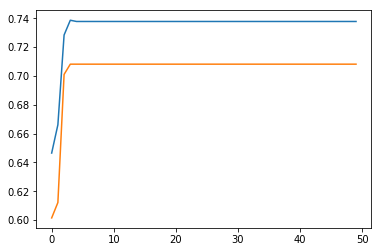

In [21]:
my_lr.train(X, y, percentage=0.8, std=True, pca=None, threshold_unbalanced=0.6, epochs=50,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

## Data imputation taken seriously
### OS

In [65]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 456245
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1221, test size 231


Weights used: {'iOS': 466.0, 'Android': 735.0, 'other': 20.0}
run=1 tscore=0.0185376 vscore=0.024
run=2 tscore=0.0185376 vscore=0.024
run=3 tscore=0.0185376 vscore=0.024
run=4 tscore=0.0185376 vscore=0.024
run=5 tscore=0.0185376 vscore=0.024
run=6 tscore=0.0185376 vscore=0.024
run=7 tscore=0.0185376 vscore=0.024
run=8 tscore=0.0185376 vscore=0.024
run=9 tscore=0.0185376 vscore=0.024
run=10 tscore=0.0185376 vscore=0.024
run=11 tscore=0.0195675 vscore=0.024
run=12 tscore=0.0195675 vscore=0.024
run=13 tscore=0.0195675 vscore=0.024
run=14 tscore=0.0195675 vscore=0.024
run=15 tscore=0.0205973 vscore=0.024
run=16 tscore=0.0226571 vscore=0.024
run=17 tscore=0.0236869 vscore=0.024
run=18 tscore=0.0236869 vscore=0.024
run=19 tscore=0.0236869 vscore=0.024
run=20 tscore=0.0236869 vscore=0.024
run=21 tscore=0.0257467 vscore=0.024
run=22 tscore=0.0257467 vscore=0.024
run=23 tscore=0.0257467 vscore=0.024
run=24 tscore=0.0267765 vscore=0.024
run=25 tscore=0.0278064 vscore=0.024
run=26 tscore=0.028836

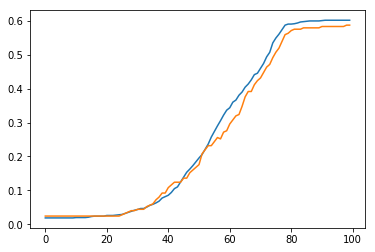

In [66]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', 
              penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight=None)

epoch=0 loss=0.8353288944212297 tscore=0.6189495365602472 vscore=0.6
epoch=1 loss=0.7292887671436002 tscore=0.6179196704428425 vscore=0.6
epoch=2 loss=0.7179456668696635 tscore=0.6220391349124614 vscore=0.6
epoch=3 loss=0.6989306803207316 tscore=0.6385169927909372 vscore=0.616
epoch=4 loss=0.6864310841308465 tscore=0.7064881565396498 vscore=0.688
epoch=5 loss=0.6792044249014321 tscore=0.709577754891864 vscore=0.684
epoch=6 loss=0.6799025741894859 tscore=0.709577754891864 vscore=0.712
epoch=7 loss=0.6657680991181828 tscore=0.6652935118434603 vscore=0.636
epoch=8 loss=0.659920216317865 tscore=0.6477857878475798 vscore=0.62
epoch=9 loss=0.6576471012697392 tscore=0.6622039134912462 vscore=0.628
epoch=10 loss=0.6539600884717258 tscore=0.7796086508753862 vscore=0.756
epoch=11 loss=0.6433933907864438 tscore=0.7991761071060762 vscore=0.816


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=12 loss=0.6437106740103938 tscore=0.7662203913491246 vscore=0.748
epoch=13 loss=0.636898877297721 tscore=0.6848609680741503 vscore=0.668
epoch=14 loss=0.6143891678553672 tscore=0.6920700308959835 vscore=0.68
epoch=15 loss=0.6039591663283586 tscore=0.694129763130793 vscore=0.668
epoch=16 loss=0.6111563336390935 tscore=0.7621009268795057 vscore=0.744
epoch=17 loss=0.584918940451741 tscore=0.768280123583934 vscore=0.736
epoch=18 loss=0.5712685050065459 tscore=0.772399588053553 vscore=0.752
epoch=19 loss=0.5553311073215015 tscore=0.7857878475798146 vscore=0.804
epoch=20 loss=0.5526849581547829 tscore=0.7672502574665293 vscore=0.756
epoch=21 loss=0.5379251130384789 tscore=0.7857878475798146 vscore=0.764
epoch=22 loss=0.5254319512058673 tscore=0.7713697219361483 vscore=0.752
epoch=23 loss=0.5262762002566109 tscore=0.7785787847579815 vscore=0.764
epoch=24 loss=0.5129348793618723 tscore=0.8125643666323378 vscore=0.804
epoch=25 loss=0.5147098979975917 tscore=0.8022657054582905 vscore=0.78

epoch=130 loss=0.3564995653867822 tscore=0.9062821833161689 vscore=0.832
epoch=131 loss=0.3604768514194097 tscore=0.8928939237899073 vscore=0.812
epoch=132 loss=0.363526042848507 tscore=0.9083419155509783 vscore=0.828
epoch=133 loss=0.36330432954652075 tscore=0.8918640576725025 vscore=0.816
epoch=134 loss=0.3627527535732898 tscore=0.8877445932028837 vscore=0.816
epoch=135 loss=0.36012295560631025 tscore=0.90216271884655 vscore=0.824
epoch=136 loss=0.3529309986073419 tscore=0.9001029866117405 vscore=0.832
epoch=137 loss=0.3507009020715759 tscore=0.9124613800205973 vscore=0.828
epoch=138 loss=0.35415725380944096 tscore=0.9031925849639547 vscore=0.824
epoch=139 loss=0.3596111033203076 tscore=0.9104016477857878 vscore=0.848
epoch=140 loss=0.36279349591197213 tscore=0.9093717816683831 vscore=0.824
epoch=141 loss=0.35987086994618517 tscore=0.893923789907312 vscore=0.812
epoch=142 loss=0.3557549114668993 tscore=0.9031925849639547 vscore=0.828
epoch=143 loss=0.35889126723368037 tscore=0.915550

epoch=243 loss=0.34256481464856486 tscore=0.9083419155509783 vscore=0.84
epoch=244 loss=0.3441128030466004 tscore=0.917610710607621 vscore=0.824
epoch=245 loss=0.34367035654752304 tscore=0.9073120494335737 vscore=0.808
epoch=246 loss=0.34436580092656965 tscore=0.9227600411946447 vscore=0.836
epoch=247 loss=0.3365186614733428 tscore=0.9052523171987642 vscore=0.828
epoch=248 loss=0.342356634188776 tscore=0.9196704428424305 vscore=0.82
epoch=249 loss=0.345152176419518 tscore=0.9207003089598352 vscore=0.832
epoch=250 loss=0.34515214076180945 tscore=0.9031925849639547 vscore=0.808
epoch=251 loss=0.3518927409884169 tscore=0.9114315139031925 vscore=0.816
epoch=252 loss=0.36441838989597053 tscore=0.9042224510813595 vscore=0.828
epoch=253 loss=0.3719649457488462 tscore=0.9237899073120495 vscore=0.836
epoch=254 loss=0.35718722281635057 tscore=0.9093717816683831 vscore=0.816
epoch=255 loss=0.3621102922220137 tscore=0.8908341915550978 vscore=0.812
epoch=256 loss=0.3568633556529461 tscore=0.9165808

epoch=360 loss=0.3526788456418138 tscore=0.9186405767250257 vscore=0.824
epoch=361 loss=0.3533583609821126 tscore=0.9268795056642637 vscore=0.836
epoch=362 loss=0.3465510287114736 tscore=0.9237899073120495 vscore=0.848
epoch=363 loss=0.34977468321729516 tscore=0.9145211122554068 vscore=0.82
epoch=364 loss=0.34826308081991125 tscore=0.9001029866117405 vscore=0.804
epoch=365 loss=0.3503823724983481 tscore=0.90216271884655 vscore=0.808
epoch=366 loss=0.3466573578252616 tscore=0.9062821833161689 vscore=0.804
epoch=367 loss=0.33705183499435604 tscore=0.9227600411946447 vscore=0.836
epoch=368 loss=0.3348122932934789 tscore=0.9062821833161689 vscore=0.816
epoch=369 loss=0.34611504595954823 tscore=0.9011328527291452 vscore=0.804
epoch=370 loss=0.34310773520829324 tscore=0.9145211122554068 vscore=0.82
epoch=371 loss=0.33655499647729964 tscore=0.92173017507724 vscore=0.824
epoch=372 loss=0.34244948447840867 tscore=0.9237899073120495 vscore=0.84
epoch=373 loss=0.33640831536654625 tscore=0.9145211

epoch=477 loss=0.33494807953945904 tscore=0.9145211122554068 vscore=0.82
epoch=478 loss=0.3327773826514385 tscore=0.925849639546859 vscore=0.848
epoch=479 loss=0.3374533609439012 tscore=0.9227600411946447 vscore=0.848
epoch=480 loss=0.34139035610173407 tscore=0.9083419155509783 vscore=0.832
epoch=481 loss=0.35827478359449566 tscore=0.9237899073120495 vscore=0.852
epoch=482 loss=0.3587043237986152 tscore=0.9268795056642637 vscore=0.836
epoch=483 loss=0.33741542066715535 tscore=0.9196704428424305 vscore=0.816
epoch=484 loss=0.3408968856046241 tscore=0.9227600411946447 vscore=0.824
epoch=485 loss=0.34474641264350797 tscore=0.9124613800205973 vscore=0.812
epoch=486 loss=0.3521573277302333 tscore=0.9001029866117405 vscore=0.792
epoch=487 loss=0.3456928094384007 tscore=0.9073120494335737 vscore=0.812
epoch=488 loss=0.3474594995336676 tscore=0.9062821833161689 vscore=0.812
epoch=489 loss=0.34962616813820674 tscore=0.9104016477857878 vscore=0.816
epoch=490 loss=0.33826355951625353 tscore=0.918

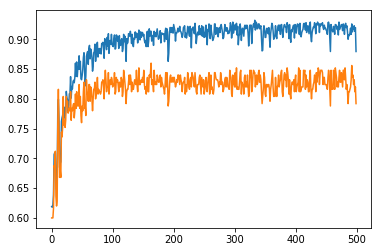

In [67]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

Weights used: {'iOS': 466.0, 'Android': 735.0, 'other': 20.0}
epoch=0 tscore=0.38928939237899074 vscore=0.344
epoch=1 tscore=0.5087538619979403 vscore=0.468
epoch=2 tscore=0.5036045314109165 vscore=0.456
epoch=3 tscore=0.5036045314109165 vscore=0.456
epoch=4 tscore=0.5036045314109165 vscore=0.456
epoch=5 tscore=0.5036045314109165 vscore=0.456
epoch=6 tscore=0.5036045314109165 vscore=0.456
epoch=7 tscore=0.5036045314109165 vscore=0.456
epoch=8 tscore=0.5036045314109165 vscore=0.456
epoch=9 tscore=0.5036045314109165 vscore=0.456
epoch=10 tscore=0.5036045314109165 vscore=0.456
epoch=11 tscore=0.5036045314109165 vscore=0.456


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=12 tscore=0.5036045314109165 vscore=0.456
epoch=13 tscore=0.5036045314109165 vscore=0.456
epoch=14 tscore=0.5036045314109165 vscore=0.456
epoch=15 tscore=0.5036045314109165 vscore=0.456
epoch=16 tscore=0.5036045314109165 vscore=0.456
epoch=17 tscore=0.5036045314109165 vscore=0.456
epoch=18 tscore=0.5036045314109165 vscore=0.456
epoch=19 tscore=0.5036045314109165 vscore=0.456
epoch=20 tscore=0.5036045314109165 vscore=0.456
epoch=21 tscore=0.5036045314109165 vscore=0.456
epoch=22 tscore=0.5036045314109165 vscore=0.456
epoch=23 tscore=0.5036045314109165 vscore=0.456
epoch=24 tscore=0.5036045314109165 vscore=0.456
epoch=25 tscore=0.5036045314109165 vscore=0.456
epoch=26 tscore=0.5036045314109165 vscore=0.456
epoch=27 tscore=0.5036045314109165 vscore=0.456
epoch=28 tscore=0.5036045314109165 vscore=0.456
epoch=29 tscore=0.5036045314109165 vscore=0.456
epoch=30 tscore=0.5036045314109165 vscore=0.456
epoch=31 tscore=0.5036045314109165 vscore=0.456
epoch=32 tscore=0.5036045314109165 vscor

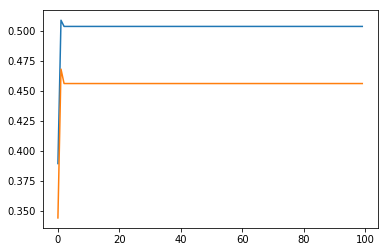

In [68]:
my_lr.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

(231, 13) (231,)
0.47619047619047616
[0.47619048 0.         0.        ]
1
(231, 13) (231,)
0.7835497835497836
[0.47619048 0.78354978 0.        ]
2
(231, 13) (231,)
0.5281385281385281
[0.47619048 0.78354978 0.52813853]
3


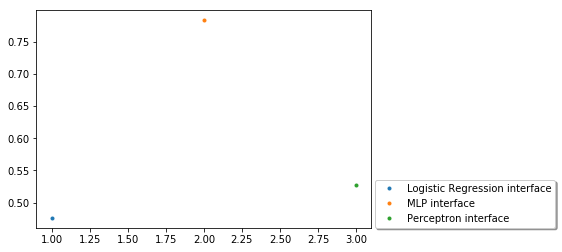

best is MLP interface with score 0.78


In [69]:
test_sup(*data.get_valid(), my_lr, my_MLP, my_perc)

Therefore we use this MLP to predict the rest of the column OS and keep the predictions to imput into our dataset later.

In [70]:
os_missing = my_MLP.predict(X,y)

# Urbanization

In [71]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['Urban'].map(lambda x: int(x), na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1424, test size 230


run=1 tscore=0.357587 vscore=0.37037
run=2 tscore=0.358474 vscore=0.377104
run=3 tscore=0.358474 vscore=0.393939
run=4 tscore=0.365572 vscore=0.393939
run=5 tscore=0.369122 vscore=0.393939
run=6 tscore=0.370896 vscore=0.424242
run=7 tscore=0.37622 vscore=0.434343
run=8 tscore=0.374445 vscore=0.427609
run=9 tscore=0.381544 vscore=0.441077
run=10 tscore=0.382431 vscore=0.43771
run=11 tscore=0.386868 vscore=0.43771
run=12 tscore=0.384206 vscore=0.434343
run=13 tscore=0.391304 vscore=0.43771
run=14 tscore=0.393079 vscore=0.434343
run=15 tscore=0.392192 vscore=0.43771
run=16 tscore=0.394854 vscore=0.447811
run=17 tscore=0.396628 vscore=0.447811
run=18 tscore=0.39929 vscore=0.454545
run=19 tscore=0.401065 vscore=0.461279
run=20 tscore=0.398403 vscore=0.464646
run=21 tscore=0.401952 vscore=0.464646
run=22 tscore=0.401952 vscore=0.468013
run=23 tscore=0.401952 vscore=0.478114
run=24 tscore=0.401952 vscore=0.481481
run=25 tscore=0.404614 vscore=0.481481
run=26 tscore=0.404614 vscore=0.481481
ru

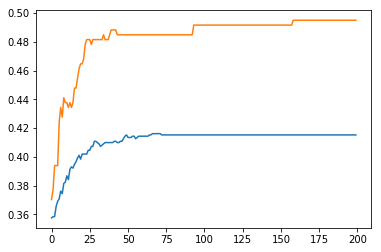

In [73]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=200,  loss='squared_hinge', 
              penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight=None)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=1.2965751276315598 tscore=0.225377107364685 vscore=0.23232323232323232
epoch=1 loss=1.2599011066888404 tscore=0.225377107364685 vscore=0.23232323232323232
epoch=2 loss=1.2359383903841528 tscore=0.225377107364685 vscore=0.23232323232323232
epoch=3 loss=1.2170767981019026 tscore=0.3513753327417924 vscore=0.2828282828282828
epoch=4 loss=1.2018265081733228 tscore=0.35581188997338065 vscore=0.2760942760942761
epoch=5 loss=1.189985986033507 tscore=0.3566992014196983 vscore=0.27946127946127947
epoch=6 loss=1.1806734605905538 tscore=0.3566992014196983 vscore=0.29292929292929293
epoch=7 loss=1.1733423949665227 tscore=0.3930789707187223 vscore=0.35353535353535354
epoch=8 loss=1.1672762677125972 tscore=0.4046140195208518 vscore=0.4511784511784512
epoch=9 loss=1.1625100988000834 tscore=0.40638864241348716 vscore=0.47474747474747475
epoch=10 loss=1.1582800370776758 tscore=0.4134871339840284 vscore=0.48148148148148145
epoch=11 loss=1.1546637231844954 tscore=0.42058562555456963 vscore=0.

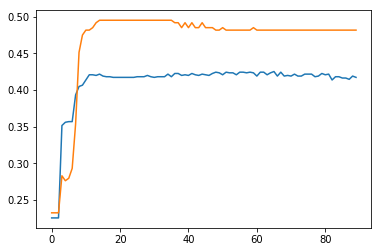

In [129]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=90,
             hidden_layer_sizes = (200,), batch_size = 50, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.10, tol = 1e-4)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=0 tscore=0.4152617568766637 vscore=0.494949494949495
epoch=1 tscore=0.4143744454303461 vscore=0.45791245791245794
epoch=2 tscore=0.4143744454303461 vscore=0.46464646464646464
epoch=3 tscore=0.4143744454303461 vscore=0.4612794612794613
epoch=4 tscore=0.4143744454303461 vscore=0.4612794612794613
epoch=5 tscore=0.4143744454303461 vscore=0.4612794612794613
epoch=6 tscore=0.4143744454303461 vscore=0.4612794612794613
epoch=7 tscore=0.4143744454303461 vscore=0.4612794612794613
epoch=8 tscore=0.4143744454303461 vscore=0.4612794612794613
epoch=9 tscore=0.4143744454303461 vscore=0.4612794612794613
epoch=10 tscore=0.4143744454303461 vscore=0.4612794612794613
epoch=11 tscore=0.4143744454303461 vscore=0.4612794612794613
epoch=12 tscore=0.4143744454303461 vscore=0.4612794612794613
epoch=13 tscore=0.4143744454303461 vscore=0.4612794612794613
epoch=14 tscore=0.4143744454303461 vscore=0.4612794612794613
epoch=15 tscore=0.4143744454303461 vscore=0.4612794612794613
epoch=16 tscore=0.414374445430346

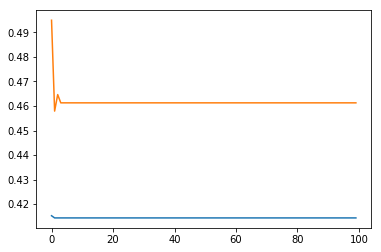

In [130]:
my_lr.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

(230, 13) (230,)
0.41739130434782606
[0.4173913 0.        0.       ]
1
(230, 13) (230,)
0.44782608695652176
[0.4173913  0.44782609 0.        ]
2
(230, 13) (230,)
0.45217391304347826
[0.4173913  0.44782609 0.45217391]
3


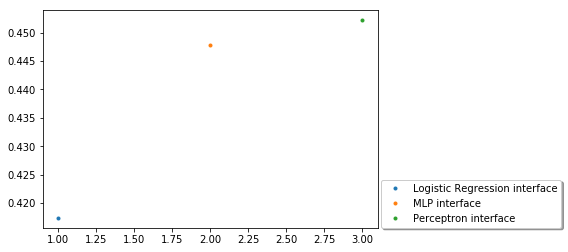

best is Perceptron interface with score 0.45


In [131]:
test_sup(*data.get_valid(), my_lr, my_MLP, my_perc)